<div class="alert alert-block alert-success">
<h1>Hooks</h1>
<h4>FEBRUARY 2014: PUZZLE</h4>
</div>

<img src="https://www.janestreet.com/puzzles/Feb14_Niedermaier.jpg" width=720 height=40 />

The puzzle was publised at https://www.janestreet.com/puzzles/hooks-index/

In the grid below, enter nine 9's in the outermost hook, eight 8's in the next hook, then seen 7's, six 6's, and so on, down to the one 1 (already entered), so that the row and column match values given along the border.

Once you've completed the puzzle, submit as your answer the sum of the values of the shaded squares (along with any other comments you'd like to provide).

<div class="alert alert-block alert-warning">
    <h1>Break down the problem</h1>
</div>

<img src="color_areas.png" width=320 height=100 />

This is a grid-based puzzle where you have a NxN grid. What we need to do is to fill cells with a number in the outermost hook from 1 to 9 which is respectively to the colors: 
* Blue: 1
* Orange: 2
* Green: 3
* Pink: 4
* Brown: 5
* Purple: 6
* Grey: 7
* Lime: 8
* Cyan: 9

And the number one 1 already entered in the upper left corner, corresponding to the blue color. The number is filled so that the sums of the rows and columns match the given border values. It means that it is not neccessary to fill all cells. 

In the submission, we need:
* Complete the puzzle
* Submit the sum of the values of the shaded squares.

<div class="alert alert-info">
  <h1>Solution</h1>
</div>

In [16]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display,HTML,Image
from z3 import *

### Tactic in Z3

In the Z3 theorem prover, **Optimizer** and **Tactic** are both components used for solving and optimizing mathematical problems. However, they have different purposes and functionality.

1. **Tactic**:

* A tactic in Z3 is a high-level strategy or a set of rules that guide the search for a solution to a problem. It defines how the solver should approach solving a given problem.
* A tactic is composed of a sequence of solver procedures, each of which tries to solve the problem in a particular way (e.g., using simplification, rewriting, or specific solver engines).
* Tactic can be applied to a goal to attempt to solve or simplify it.

2. **Optimizer**:
* An optimizer in Z3 is used for optimizing mathematical expressions or finding optimal solutions to optimization problems (e.g., minimizing or maximizing a function subject to constraints).
* The optimizer is used for numerical optimization, where the goal is to find the optimal values of variables that satisfy certain conditions to either maximize or minimize an objective function.
* The Optimizer in Z3 allows you to specify optimization objectives and constraints, and it can search for optimal solutions using various optimization strategies.

In summary, a Tactic is more general and focused on guiding the solving process and simplifying goals, while an Optimizer is specifically designed for numerical optimization problems, attempting to find optimal solutions for given optimization objectives and constraints. Tactics can be used as part of an optimization process to guide how the optimization is performed, but they serve different purposes in the context of Z3.

### QF_FD Logic

A specialized logic QF_FD (stands for quantifier-free formulas over finite domains.) and associated incremental solver (that supports push/pop). The QF_FD domain comprises of bit-vectors, enumeration data-types used only in equalities, and bounded integers: Integers used in QF_FD problems have to be constrained by a finite bound.

Here's a simple example of using Z3 with a tactic for solving a quantifier-free formula in the **QF_FD logic**:

In [62]:
# Create Z3 solver
# Use a tactic for solving QF_FD formulas
solver = Tactic('qffd').solver()

# Define variables
x = Int('x')
y = Int('y')

# Create a quantifier-free formula over finite domains (QF_FD)
formula = And(x > 0, y > 0, x < 10, y < 10, x + y == 15)

# Add the formula to the solver
solver.add(formula)

if solver.check() == sat:
    print("Satisfiable")
    print("Model:")
    model = solver.model()
    print("x =", model[x])
    print("y =", model[y])
elif solver.check() == unsat:
    print("Unsatisfiable")
else:
    print("Unknown")

Satisfiable
Model:
x = 7
y = 8


### Brainstorm

In [123]:
# Setup up a 9 x 9 grid according to the requirement
grid = np.zeros((9,9)) # all values are 0
for (i,j),e in np.ndenumerate(grid): #increasing the outermost values up 1 unit.
    grid[i,j] = max(i,j)+1

In [124]:
grid

array([[1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [2., 2., 3., 4., 5., 6., 7., 8., 9.],
       [3., 3., 3., 4., 5., 6., 7., 8., 9.],
       [4., 4., 4., 4., 5., 6., 7., 8., 9.],
       [5., 5., 5., 5., 5., 6., 7., 8., 9.],
       [6., 6., 6., 6., 6., 6., 7., 8., 9.],
       [7., 7., 7., 7., 7., 7., 7., 8., 9.],
       [8., 8., 8., 8., 8., 8., 8., 8., 9.],
       [9., 9., 9., 9., 9., 9., 9., 9., 9.]])

In [125]:
# The numbers outside the rows.
row_labels = [31, 19, 45, 16, 5, 47, 28, 49, 45]
# The numbers outside the columns.
col_labels = [26, 42, 11, 22, 42, 36, 29, 32, 45]

In [130]:
# Setup up a 9x9 matrix of integer variables and solver 
X = np.array(IntVector("x",9*9),dtype=object).reshape((9,9))
s = Tactic('qffd').solver()

In [134]:
# constraints
s += [Or(x==0,x==1) for _,x in np.ndenumerate(X)] # Because we can leave the cell blank (0) or put a number (1)
# s += [np.sum(X[i,:]*grid[i,:])==e for i,e in enumerate(col_labels)] # Sum values in the column to get the value equal to the corresponding given border value.
for i in range(9):
    s += Sum([X[i][j] * int(grid[i][j]) for j in range(9)]) == col_labels[i]
# s += [np.sum(X[:,i]*grid[:,i])==e for i,e in enumerate(row_labels)] # Sum values in the row to get the value equal to the corresponding given border value.
for j in range(9):
    s += Sum([X[i][j] * int(grid[i][j]) for i in range(9)]) == row_labels[j]
s += [PbEq([(e*int(grid[i,j])==n,1) for (i,j),e in np.ndenumerate(X)],n) for n in range(1,10)] # Combine both column and row sums conditions

<div class="alert alert-block alert-warning">
<b>Warning:</b> The values returned by grid[i][j] were not integers, so we need to change their type before applying the any mathematical operations.
</div>

### PbEq in z3

**PbEq** in Z3 stands for "pseudo-Boolean equality constraint," which is a type of constraint used in pseudo-Boolean optimization. Pseudo-Boolean optimization is a generalization of Boolean optimization where variables are allowed to take values from a larger domain (usually integers) rather than just true or false.

In Z3, PbEq is a function that creates a pseudo-Boolean equality constraint. The pseudo-Boolean equality constraint is typically expressed as a weighted sum of Boolean variables (often called pseudo-Boolean variables) being equal to a given integer constant. It has the general form:

$$a1 * x1 + a2 * x2 + ... + an * xn == k$$

Here, x1, x2, ..., xn are Boolean variables, a1, a2, ..., an are their corresponding weights (usually integers), and k is the target integer constant.

Here's a simple example of using **PbEq** in z3:

In [82]:
# Define the Boolean variables
x1 = Bool('x1')
x2 = Bool('x2')
x3 = Bool('x3')

# Define the weights for the Boolean variables
a1 = 2
a2 = -1
a3 = 3

# Define the target integer constant
k = 1

# Create the pseudo-Boolean equality constraint: a1 * x1 + a2 * x2 + a3 * x3 == k
pb_eq_constraint = PbEq([(x1, a1), (x2, a2), (x3, a3)], k)

# Print the pseudo-Boolean equality constraint
print("Pseudo-Boolean equality constraint:", pb_eq_constraint)

Pseudo-Boolean equality constraint: PbEq(((x1, 2), (x2, -1), (x3, 3)), 1)


In this example, we create a pseudo-Boolean equality constraint $$2 * x1 - x2 + 3 * x3 == 1$$

**Solved in 0.1489 seconds. Answer is : 158**

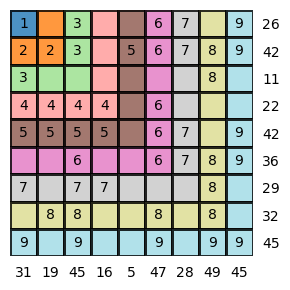

In [132]:
# Solve and print 
start =  time.time()
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    r = evalu(X)
else:
    print("Failed")
    
display(Markdown("**Solved in {:.4f} seconds. Answer is : {:.0f}**".format(time.time()-start,
                                                                   sum([e for (i,j),e in np.ndenumerate(r*grid) if (i+j) % 2 ==0])
                                                                  )))
fig,ax = plt.subplots(1,1,figsize=(3,3))
pretty = np.vectorize(lambda x:str(int(x)).replace('0',''))
ax = sns.heatmap(grid,annot=pretty(r*grid),fmt='',cbar=False,cmap="tab20",linecolor='k',linewidth=2,
                 xticklabels=row_labels, yticklabels=col_labels, annot_kws={"fontsize":10,"color":"k"},alpha=0.8)
ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
plt.xticks(rotation=0,fontsize =10)
plt.yticks(rotation=0,fontsize =10)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  <h1>Public Solution</h1>
</div>

<img src="https://www.janestreet.com/puzzles/Feb14_Solution.png" width=720 height=50 />

The BEST SOLUTION was publised at https://www.janestreet.com/puzzles/hooks-solution/